# Task5. Unsupervised learning


In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Датасет

[Набор данных](https://www.kaggle.com/datasets/zalando-research/fashionmnist) содержит  небольшие изображения (28x28 пикселей) различных элементов одежды. Для работы были взяты данные из тренировочной выборки.

Данные представляют собой таблицу, в первой колонке которой указан тип элемента одежды, а в последующих значение каждого из 28x28 пикселей.

In [173]:
df = pd.read_csv('/content/fashion-mnist_train.csv').head(30000)


# EDA

In [174]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 179.7 MB


Мы видим, что всего представлено 10 различных типов одежды, каждый из которых пронумерован меткой от 0 до 9.

In [176]:
df["label"].value_counts()

label
7    3056
6    3038
0    3037
3    3013
1    3002
8    2993
2    2992
9    2987
5    2982
4    2900
Name: count, dtype: int64

Проверим есть ли нулевые значения:

In [177]:
df.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [178]:
labels = df["label"]
df.drop(columns=["label"], inplace=True)

# PCA

In [179]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca_result = pca.fit_transform(df)

CPU times: user 4.22 s, sys: 358 ms, total: 4.57 s
Wall time: 4.63 s


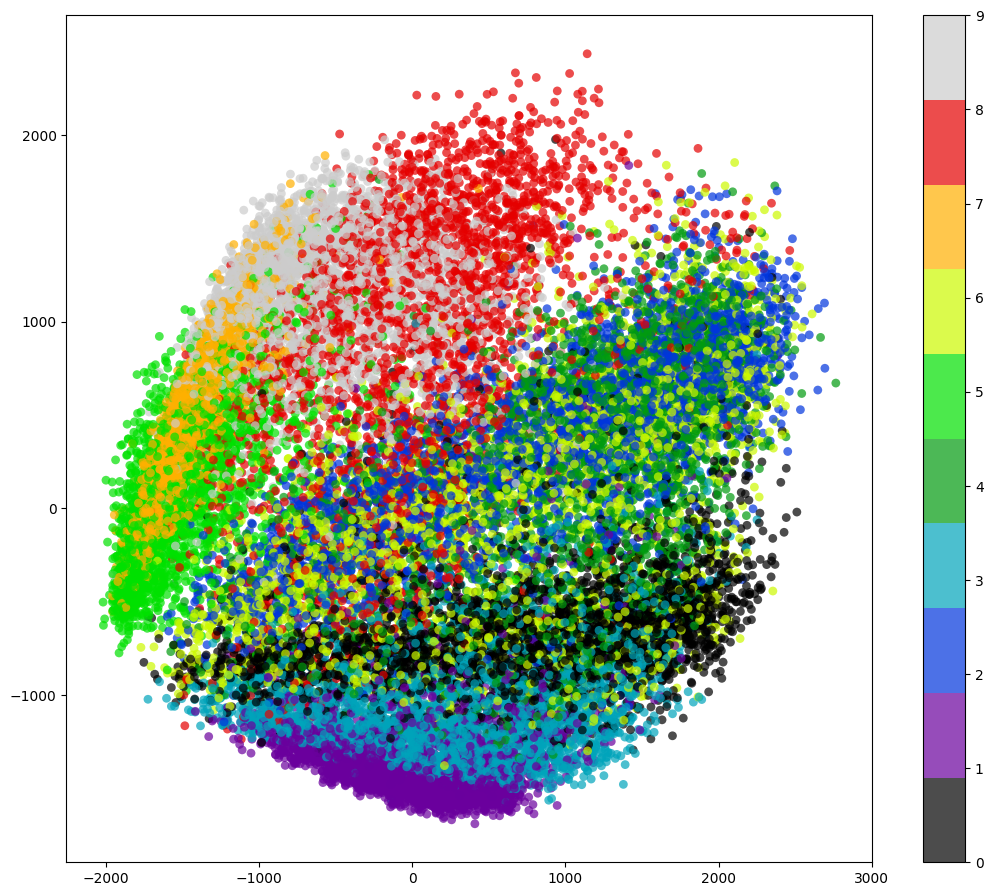

In [195]:
plt.figure(figsize=(13, 11))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

# t-SNE

In [181]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
df_reduced = tsne.fit_transform(df)

CPU times: user 11min 56s, sys: 1 s, total: 11min 57s
Wall time: 7min 14s


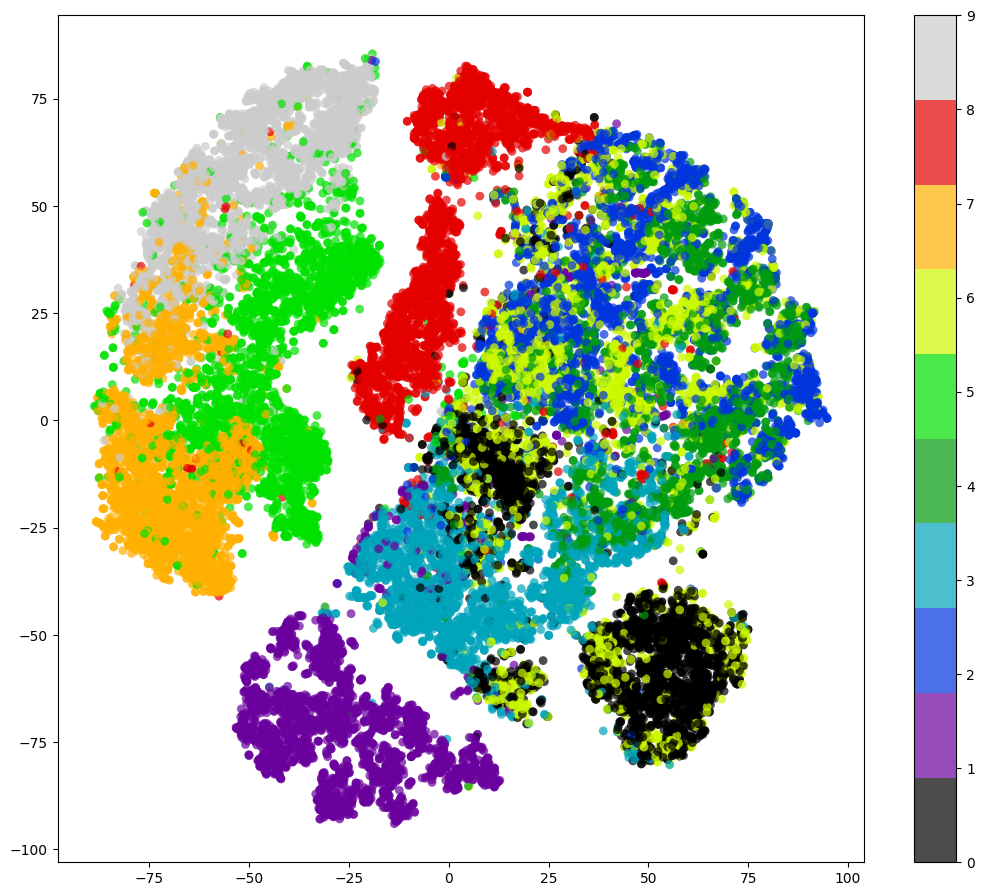

In [196]:
plt.figure(figsize=(13, 11))
plt.scatter(
    df_reduced[:, 0],
    df_reduced[:, 1],
    c=labels,
    edgecolor="none",
    alpha=0.7,
    s=40,
    cmap=plt.cm.get_cmap("nipy_spectral", 10),
)
plt.colorbar()

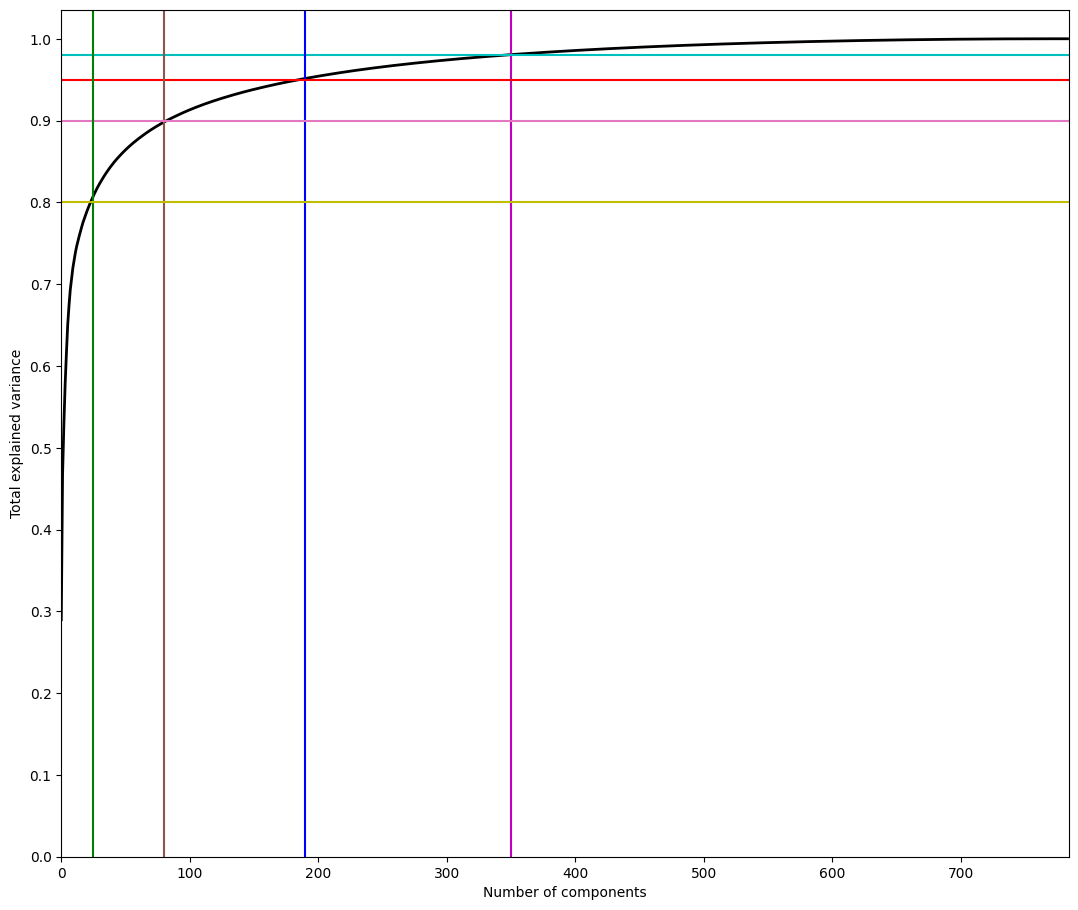

In [183]:
pca = PCA().fit(df)

plt.figure(figsize=(13, 11))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, int(np.sqrt(len(df.columns))) * int(np.sqrt(len(df.columns))))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(350, c='m')
plt.axhline(0.98, c='c')
plt.axvline(190, c='b')
plt.axhline(0.95, c='r')
plt.axvline(80, c='tab:brown')
plt.axhline(0.90, c='tab:pink')
plt.axvline(25, c='g')
plt.axhline(0.80, c='y')
plt.show();

Мы видим, что нам достаточно всего 200 компонентов, чтобы описать более 95% всей дисперсии, дальнейшее увеличение компонент не так сильно увеличивает дисперсию. По этой причине мы можем значительно уменьшить размер нашего набора данных без ощутимых последствий для последующей точности модели.



In [184]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted


class OwnKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def predict(self, x):
        check_is_fitted(self)
        return self._get_labels(check_array(x))

    def fit(self, x, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        x = check_array(x)

        self.n_features_in_ = x.shape[1]
        self.cluster_centers_ = x[self.random_state_.choice(len(x), size=self.n_clusters, replace=False), :]
        max_center_shift = np.inf

        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(x)

            new = np.empty((self.n_clusters, self.n_features_in_))
            for i in np.unique(self.labels_):
                new[i] = np.mean(x[self.labels_ == i], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new, axis=1))

            self.cluster_centers_ = new

        return self

    def _get_labels(self, x):
        return np.argmin(
            np.linalg.norm(x[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )



# Обучение

Используемые метрики:
* ARI
* AMI
* FMI

Размерность компонент датасета при обучении:
* 25 -- 80%
* 80 -- 90%
* 190 -- 95%
* 350 -- 98%

In [185]:
%%time
xs = [df, *(PCA(n_components=i).fit_transform(df) for i in [25, 80, 190, 350])]

CPU times: user 21.5 s, sys: 972 ms, total: 22.5 s
Wall time: 22.4 s


In [186]:
import itertools, time
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.base import clone

def train(est, params):
    params_combs = [
        dict(param) for param in
        itertools.product(*([(name, v) for v in vs] for (name, vs) in params.items()))
    ]

    results = []
    for x in xs:
        best_ari = None
        best_ami = None
        best_fmi = None

        for param in params_combs:
            e = clone(est).set_params(**param)
            start_time = time.perf_counter()
            pred = e.fit_predict(x)
            pred_time = (time.perf_counter() - start_time)

            ari = adjusted_rand_score(labels, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, pred_time, param

            ami = adjusted_mutual_info_score(labels, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, pred_time, param

            fmi = fowlkes_mallows_score(labels, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, pred_time, param

        res = {
            "Cluster": est.__class__.__name__,
            "Dimensions": x.shape[1],
            "Mean fit predict time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
            "Best ARI": best_ari[0],
            "Best AMI": best_ami[0],
            "Best FMI": best_fmi[0]
        }

        print(
            f"Best params for {x.shape[1]}:",
            f"By ARI: {best_ari[2]}",
            f"By AMI: {best_ami[2]}",
            f"By FMI: {best_fmi[2]}",
            sep="\n",
            )

        print(res)
        results.append(res)

    return results

# OwnKMeans

In [187]:
%%time

own_kmeans = train(
    OwnKMeans(n_clusters=10, random_state=0),
    params={} # There are no parameters in OwnKMeans
)

Best params for 784:
By ARI: {}
By AMI: {}
By FMI: {}
{'Cluster': 'OwnKMeans', 'Dimensions': 784, 'Mean fit predict time, s': 109.67509047100066, 'Best ARI': 0.3173994449300282, 'Best AMI': 0.4862473473603674, 'Best FMI': 0.39235605864580037}
Best params for 25:
By ARI: {}
By AMI: {}
By FMI: {}
{'Cluster': 'OwnKMeans', 'Dimensions': 25, 'Mean fit predict time, s': 5.46760648199961, 'Best ARI': 0.347365767933994, 'Best AMI': 0.5117612297601166, 'Best FMI': 0.41962983819346306}
Best params for 80:
By ARI: {}
By AMI: {}
By FMI: {}
{'Cluster': 'OwnKMeans', 'Dimensions': 80, 'Mean fit predict time, s': 6.94479248800053, 'Best ARI': 0.3172134157291903, 'Best AMI': 0.4860713020388199, 'Best FMI': 0.392190066752814}
Best params for 190:
By ARI: {}
By AMI: {}
By FMI: {}
{'Cluster': 'OwnKMeans', 'Dimensions': 190, 'Mean fit predict time, s': 15.498069700999622, 'Best ARI': 0.31737084250983033, 'Best AMI': 0.486234863483658, 'Best FMI': 0.3923301626287638}
Best params for 350:
By ARI: {}
By AMI: 

# K-means from sklearn

In [188]:
%%time
from sklearn.cluster import KMeans

kmeans = train(
    KMeans(n_clusters=10, n_init='auto', random_state=0),
    params={"algorithm": ["lloyd", "elkan"]}
)

Best params for 784:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}
{'Cluster': 'KMeans', 'Dimensions': 784, 'Mean fit predict time, s': 5.250171257001057, 'Best ARI': 0.36783792995142417, 'Best AMI': 0.49994730728647313, 'Best FMI': 0.43407089262929277}
Best params for 25:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}
{'Cluster': 'KMeans', 'Dimensions': 25, 'Mean fit predict time, s': 0.11527193799884117, 'Best ARI': 0.34713628852892764, 'Best AMI': 0.5116201286832043, 'Best FMI': 0.41937782646827154}
Best params for 80:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}
{'Cluster': 'KMeans', 'Dimensions': 80, 'Mean fit predict time, s': 0.5171431800008577, 'Best ARI': 0.33940567227256163, 'Best AMI': 0.49085430633308214, 'Best FMI': 0.40934153420073416}
Best params for 190:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algori

# DBSCAN from sklearn

In [189]:
%%time
from sklearn.cluster import DBSCAN

dbscan = train(
    DBSCAN(n_jobs=4),
    params={
        "eps": [128, 256, 512, 1024],
        "min_samples": [16, 32, 64, 128, 256]
    }
)

Best params for 784:
By ARI: {'eps': 1024, 'min_samples': 64}
By AMI: {'eps': 1024, 'min_samples': 256}
By FMI: {'eps': 128, 'min_samples': 16}
{'Cluster': 'DBSCAN', 'Dimensions': 784, 'Mean fit predict time, s': 81.49410809466644, 'Best ARI': 0.04963002952579297, 'Best AMI': 0.1732645442864282, 'Best FMI': 0.3162097188357903}
Best params for 25:
By ARI: {'eps': 512, 'min_samples': 64}
By AMI: {'eps': 512, 'min_samples': 64}
By FMI: {'eps': 512, 'min_samples': 64}
{'Cluster': 'DBSCAN', 'Dimensions': 25, 'Mean fit predict time, s': 5.445270142001391, 'Best ARI': 0.09631856893663168, 'Best AMI': 0.33513564022350917, 'Best FMI': 0.32970237698352534}
Best params for 80:
By ARI: {'eps': 1024, 'min_samples': 256}
By AMI: {'eps': 512, 'min_samples': 16}
By FMI: {'eps': 128, 'min_samples': 16}
{'Cluster': 'DBSCAN', 'Dimensions': 80, 'Mean fit predict time, s': 7.0713675779995055, 'Best ARI': 0.04780019137834679, 'Best AMI': 0.16890227767639535, 'Best FMI': 0.3162097188357903}
Best params for 1

# Результаты

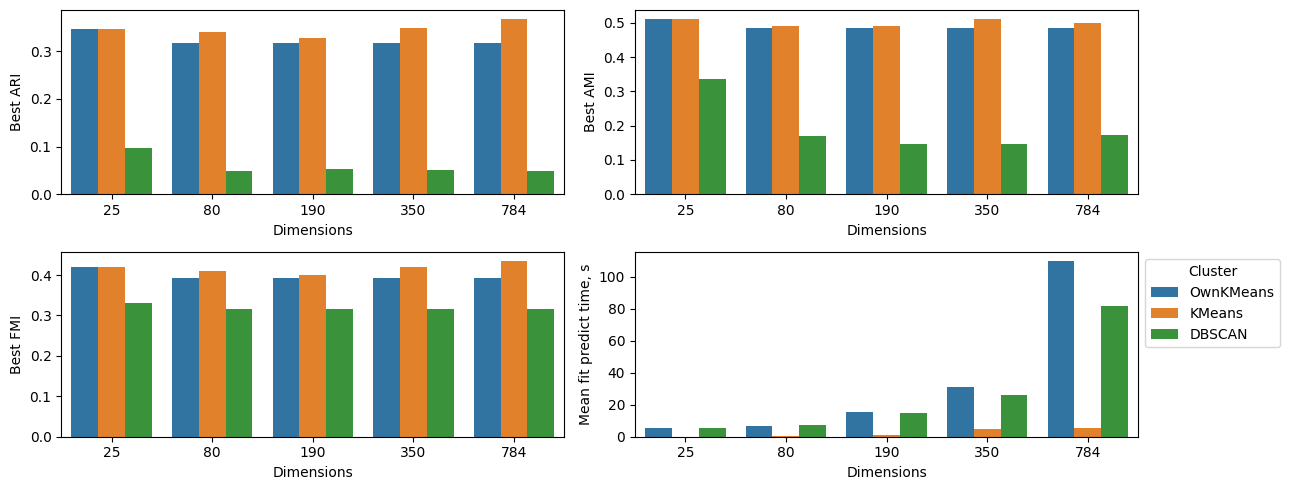

In [192]:
results = pd.DataFrame(own_kmeans + kmeans + dbscan)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(13, 5))

for metric, ax in zip(["Best ARI", "Best AMI", "Best FMI", "Mean fit predict time, s"], axs.flatten()):
    sns.barplot(results, x="Dimensions", y=metric, hue="Cluster", ax=ax)
    if metric == "Mean fit predict time, s":
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()

fig.tight_layout()

По графикам видно, что размерность входных параметров не оказывает практически никакого внимания на конечный результат. Наиболее быстрообучаемой моделью является -- KMeans из sklean, другие модели требуют ощутимо больше времени на обучение при увеличении количества входных данных.

Хуже всего на всех метриках (ARI, AMI, FMI) показал себя алгоритм DBSCAN из sklearn. А алгоритмы OwnKMeans и KMeans показывают примерно одинаковые результаты.